# What is the difference between complex-valued fMRI data and analytic signal estimated from the magnitude fMRI data?

I've seen "complex-valued signal" used in reference to fMRI data in two ways:

1. In one camp, we have research using the complex-valued data coming from the scanner. In most cases, folks discard the phase data and just retain the magnitude data. However, the phase data can be used in multiple ways:
    - Phase regression: regress the phase time series from the magnitude time series to suppress signals from macrovasculature and better localize to the microvasculature we care about ([Menon, 2002](https://doi.org/10.1002/mrm.10041); [Curtis, Hutchison, & Menon, 2014](https://doi.org/10.1016/j.neuroimage.2014.05.079); [Stanley et al., 2021](https://doi.org/10.1016/j.neuroimage.2020.117631)). Key researchers in this area seem to be Ravi S. Menon and Daniel B. Rowe.
    - Joint magnitude and phase modeling: I'm not sure how distinct this is from phase regression, but it looks like these methods include both the magnitude and phase signals in the analysis model, rather than as a distinct denoising step. Some papers: [Rowe (2005)](https://doi.org/10.1016/j.neuroimage.2005.01.034), [Adrian, Maitra, & Rowe (2019)](https://doi.org/10.1214%2F17-AOAS1117). The main researcher in this area seems to be Daniel B. Rowe.
    - Dynamic distortion correction: Many field mapping methods use magnitude and phase images from two very close echo times in order to produce a field map. Something like this approach can be applied to complex-valued _time series_ ([Dymerska et al., 2018](https://doi.org/10.1016/j.neuroimage.2016.07.009)).
    - Complex ICA: Performing ICA on the complex-valued data. Some papers: [Adali & Calhoun (2007)](https://doi.org/10.1109/SP.2007.904742), [Calhoun & Adali (2012)](https://doi.org/10.2478/v10175-012-0050-5). Major names in this area seem to be Vince Calhoun and Tulay Adali.
    - Functional quantitative susceptibility mapping (fQSM): When combined with a multi-echo protocol, complex-valued data can be used to quantify susceptibility over time ([Kiersnowski et al., 2021](https://www.researchgate.net/profile/Oliver-Kiersnowski/publication/365275746_Simultaneous_Multi-Slice_Acceleration_of_Multi-Echo_EPI_Provides_Rapid_and_Accurate_Quantitative_Susceptibility_Mapping/links/636cf2f52f4bca7fd04b9ece/Simultaneous-Multi-Slice-Acceleration-of-Multi-Echo-EPI-Provides-Rapid-and-Accurate-Quantitative-Susceptibility-Mapping.pdf)).
2. In the other camp, we have research using the magnitude-only data most neuroimagers use. In these papers, a Hilbert transform is applied to the magnitude data to produce the complex-valued "analytic signal". The authors of these papers generally refer to the analytic signal as "complex-valued signal", without noting any differences from (or the existence of) the original complex-valued data.
    - Papers: [Laird et al. (2002)](https://doi.org/10.1002%2Fhbm.10027), [Glerean et al. (2012)](https://doi.org/10.1089/brain.2011.0068), [Bolt et al. (2018)](https://doi.org/10.1016/j.neuroimage.2018.04.015), [Bolt et al. (2022)](https://doi.org/10.1038/s41593-022-01118-1).

I haven't come across **any** papers that have discussed both types of data. None of them seem to even acknowledge the other.

In [1]:
%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import seaborn as sns
from nilearn import image, maskers, masking, plotting
from scipy.signal import hilbert

sys.path.append('/Users/taylor/Documents/tsalo/complex-flow/')
from complex_utils import to_radians

sns.set_style("whitegrid")

In [2]:
def to_complex(mag, phase):
    real = mag / np.sqrt(np.tan(phase) ** 2 + 1)
    imag = np.tan(phase) * real
    comp = real + (1j * imag)
    return comp

In [3]:
magnitude_file = (
    "/Users/taylor/Documents/datasets/ds002278/sub-PILOT/ses-01/func/"
    "sub-PILOT_ses-01_task-StrangerThingsS01E01_run-01_echo-2_bold.nii.gz"
)
phase_file = (
    "/Users/taylor/Documents/datasets/ds002278/sub-PILOT/ses-01/func/"
    "sub-PILOT_ses-01_task-StrangerThingsS01E01_run-01_echo-2_phase.nii.gz"
)

/opt/miniconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
<ipython-input-4-1c6e282ba1b7>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


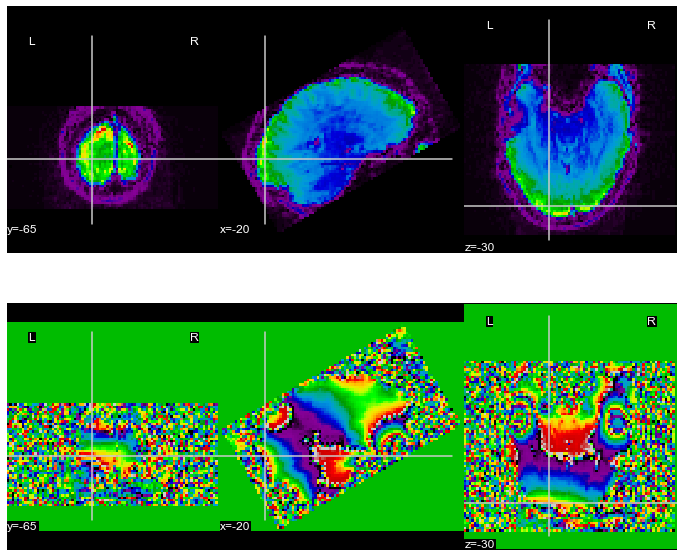

In [4]:
xyz = [-20, -65, -30]
fig, axes = plt.subplots(figsize=(12, 10), nrows=2)
img_to_plot = image.index_img(magnitude_file, 20)
plotting.plot_epi(img_to_plot, bg_img=None, cut_coords=xyz, axes=axes[0], figure=fig)
img_to_plot = image.index_img(phase_file, 20)
plotting.plot_epi(img_to_plot, bg_img=None, cut_coords=xyz, axes=axes[1], figure=fig)
fig.show()

In [5]:
masker = maskers.NiftiSpheresMasker(seeds=[xyz], radius=None)
masker.fit()
m_data = np.squeeze(masker.transform(magnitude_file))
p_data = np.squeeze(masker.transform(to_radians(phase_file)))
p_data_unwrapped = np.unwrap(p_data)
c_data = to_complex(m_data, p_data_unwrapped)
r_data = c_data.real
i_data = c_data.imag

<ipython-input-7-f8c997df3caf>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


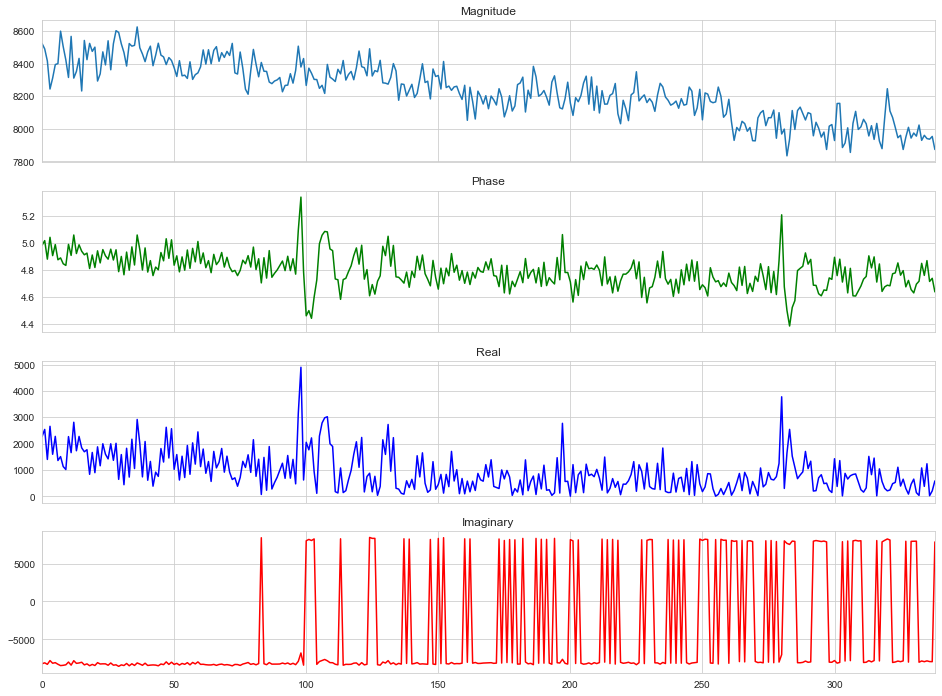

In [7]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 12), sharex=True)
axes[0].plot(m_data)
axes[0].set_title('Magnitude')
axes[1].plot(p_data_unwrapped, color='green')
axes[1].set_title('Phase')
axes[2].plot(r_data, color='blue')
axes[2].set_title('Real')
axes[3].plot(i_data, color='red')
axes[3].set_title('Imaginary')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

<ipython-input-8-cec28e45fa62>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


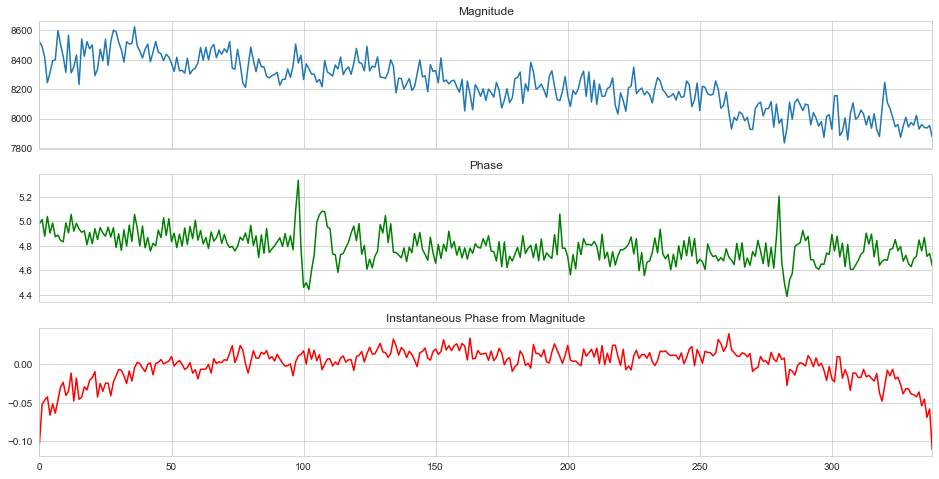

In [8]:
# For the basis for this, see
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
analytic_signal_from_mag = hilbert(m_data)
amplitude_envelope_from_mag = np.abs(analytic_signal_from_mag)
instantaneous_phase_from_mag = np.unwrap(np.angle(analytic_signal_from_mag))

fig, axes = plt.subplots(nrows=3, figsize=(16, 8), sharex=True)
axes[0].plot(m_data)
axes[0].set_title('Magnitude')
axes[1].plot(p_data, color='green')
axes[1].set_title('Phase')
axes[2].plot(instantaneous_phase_from_mag, color='red')
axes[2].set_title('Instantaneous Phase from Magnitude')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

<ipython-input-9-4628f80b918e>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


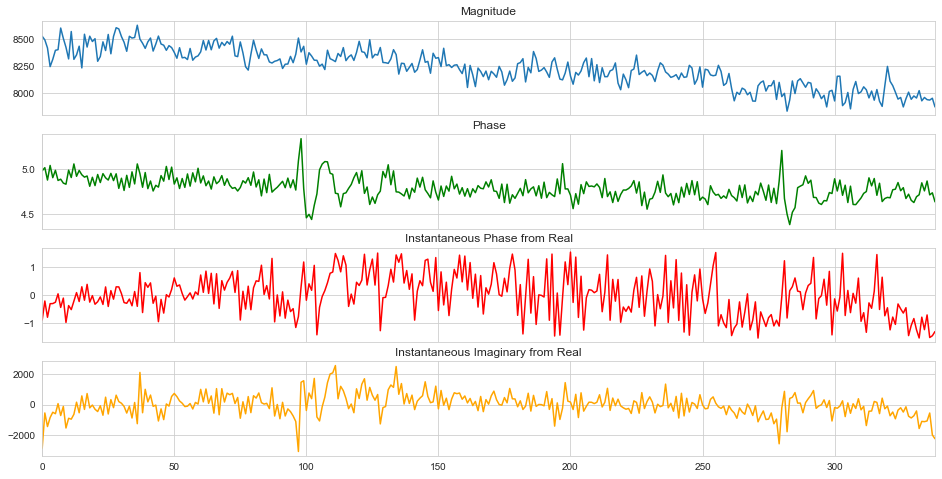

In [9]:
analytic_signal_from_real = hilbert(r_data)
amplitude_envelope_from_real = np.abs(analytic_signal_from_real)
instantaneous_phase_from_real = np.unwrap(np.angle(analytic_signal_from_real))

fig, axes = plt.subplots(nrows=4, figsize=(16, 8), sharex=True)
axes[0].plot(m_data)
axes[0].set_title('Magnitude')
axes[1].plot(p_data, color='green')
axes[1].set_title('Phase')
axes[2].plot(instantaneous_phase_from_real, color='red')
axes[2].set_title('Instantaneous Phase from Real')
axes[3].plot(analytic_signal_from_real.imag, color='orange')
axes[3].set_title('Instantaneous Imaginary from Real')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

In [10]:
np.corrcoef(i_data, analytic_signal_from_real.imag)

array([[ 1.        , -0.02226182],
       [-0.02226182,  1.        ]])

In [11]:
np.corrcoef(p_data, instantaneous_phase_from_mag)

array([[ 1.       , -0.1487853],
       [-0.1487853,  1.       ]])

<ipython-input-12-629a7dfc2215>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


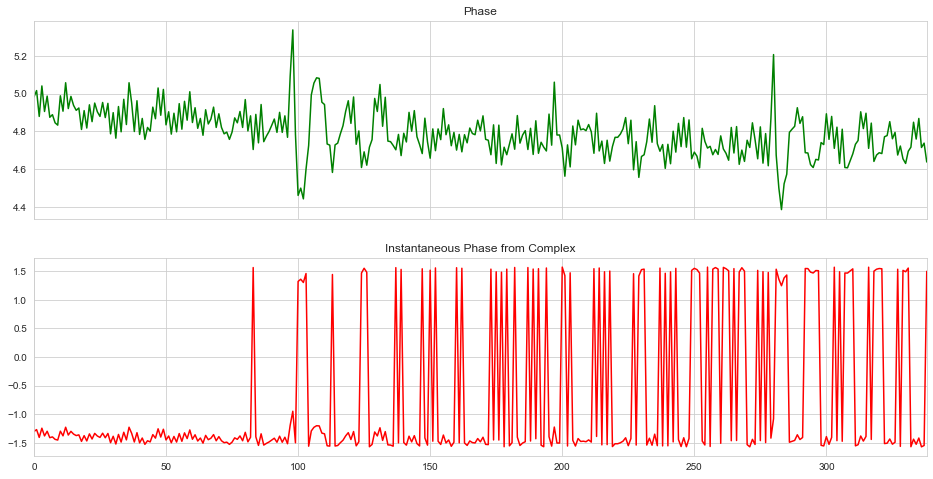

In [12]:
instantaneous_phase_forreal = np.angle(c_data)
fig, axes = plt.subplots(nrows=2, figsize=(16, 8), sharex=True)
axes[0].plot(p_data, color='green')
axes[0].set_title('Phase')
axes[1].plot(instantaneous_phase_forreal, color='red')
axes[1].set_title('Instantaneous Phase from Complex')
axes[0].set_xlim(0, m_data.shape[0] - 1)
fig.show()

In [13]:
np.corrcoef(i_data, p_data)

array([[ 1.       , -0.6844661],
       [-0.6844661,  1.       ]])

In [14]:
np.corrcoef(r_data, p_data)

array([[1.        , 0.72358045],
       [0.72358045, 1.        ]])

In [15]:
np.corrcoef(m_data, p_data)

array([[1.        , 0.41827968],
       [0.41827968, 1.        ]])

In [16]:
np.corrcoef(m_data, r_data)

array([[1.        , 0.34442109],
       [0.34442109, 1.        ]])

In [17]:
np.corrcoef(m_data, i_data)

array([[ 1.        , -0.37327493],
       [-0.37327493,  1.        ]])